# Extracting Roles

In [1]:
from group_formations import DATA_PATH
# Imports and deactivate warnings
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

from floodlight.io.dfl import read_position_data_xml
from roles import extract_roles, get_role_heatmaps

from data_processing import load_event_data
from visualization import load_data, plot_event_count, plot_kde, plot_goal_positions

# Define the path to the dataset
path = DATA_PATH
# Display Data Summary. Note that executing this code can take several minutes due the complexity of the parsing routines.
# display_data_summary(path)

In [2]:
import xml.etree.ElementTree as ET


def extract_game_title_from_xml_file(file_path):
    """
    Parses an XML file and extracts the MatchTitle attribute.

    Args:
        file_path (str): The path to the XML file.

    Returns:
        str or None: The extracted MatchTitle or None if not found.
    """
    if not os.path.exists(file_path):
        print(f"Error: File not found at path: {file_path}")
        return None

    try:
        # Use ET.parse() to read and parse the XML file
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Find the General element within MatchInformation
        # Using XPath-like syntax
        general_element = root.find('./MatchInformation/General')

        # Extract the MatchTitle attribute
        if general_element is not None:
            match_title = general_element.get('MatchTitle')
            return match_title
        else:
            print("Could not find the MatchInformation/General element.")
            return None

    except ET.ParseError as e:
        print(f"Error parsing XML file: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None


In this loop, we group by specified formation in the match_information (e.g. 4-2-3-1) and we stack all positions in an appropriate way per match formation. We then call the logic of extracting player positions.

1. FC Köln:FC Bayern München
Number of players: 16
Number of roles (K): 11
Number of bins (L): 294
Grid shape: (14, 21)
Reconstruction error: 0.5893

Player role assignments (dominant role per player):
[ 8  4  6  1 10  9  5  2  0  3  7  5  7  5  0  0]


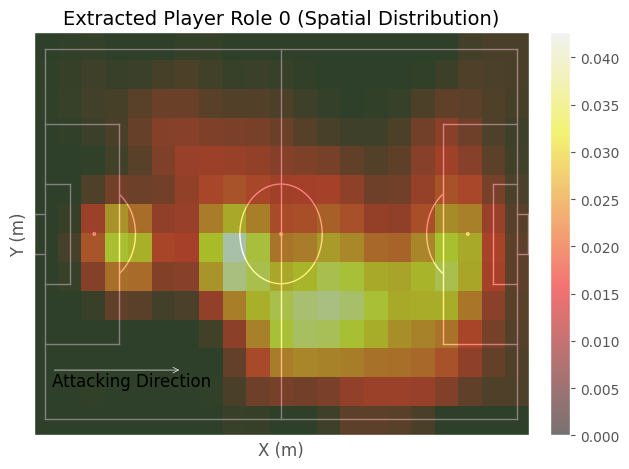

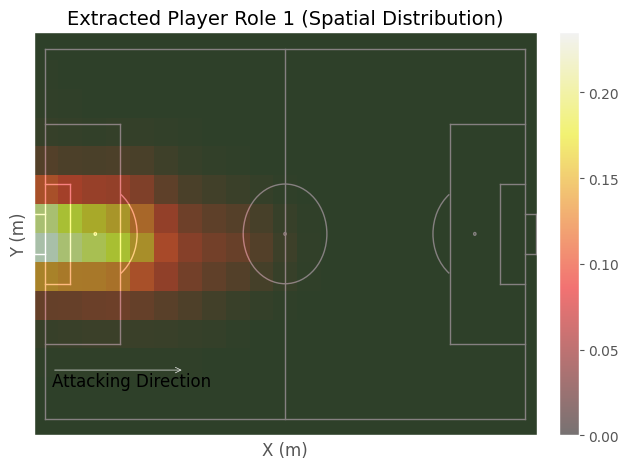

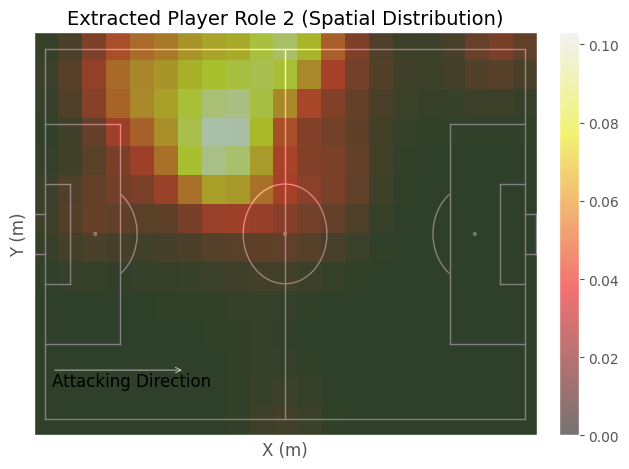

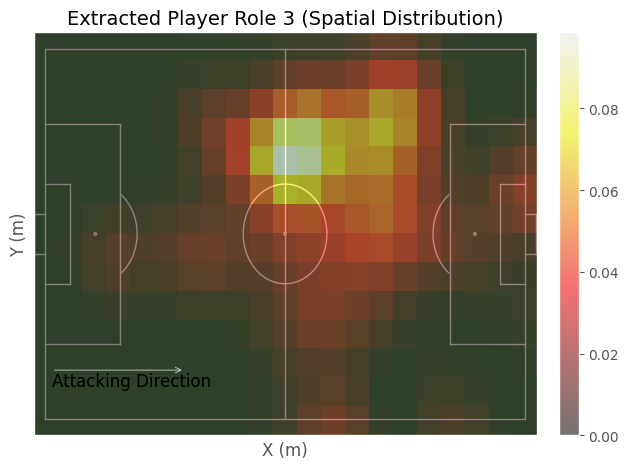

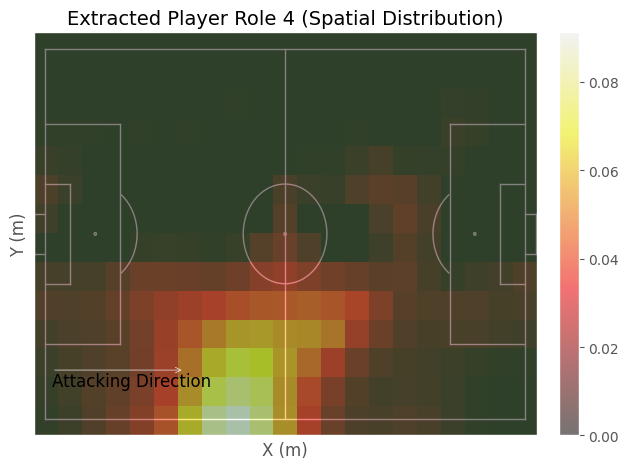

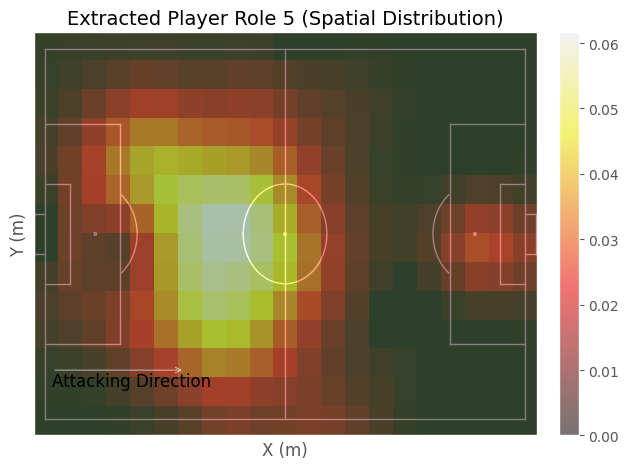

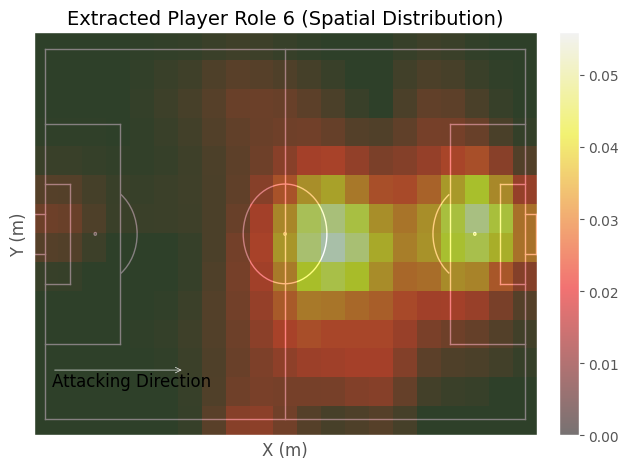

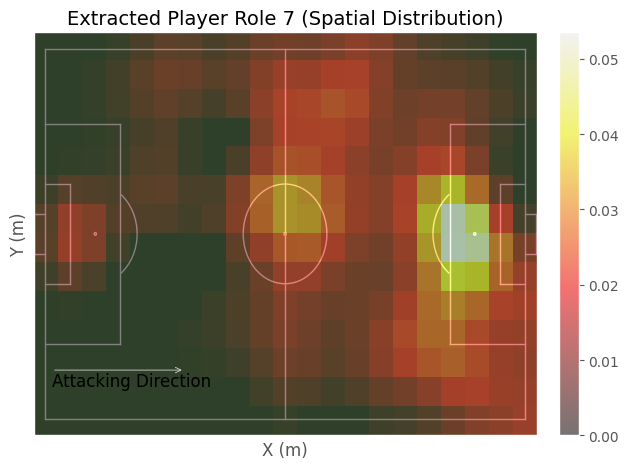

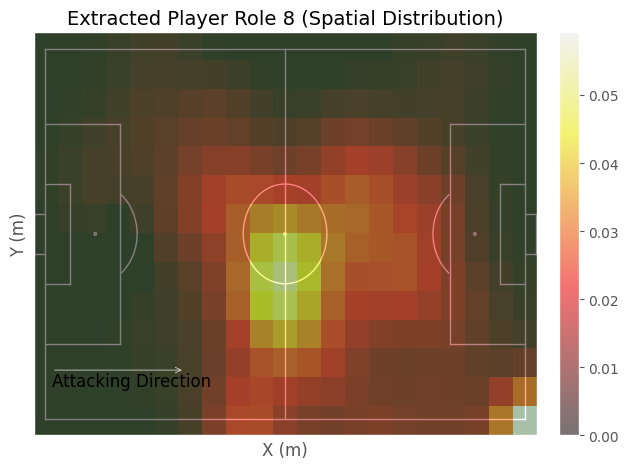

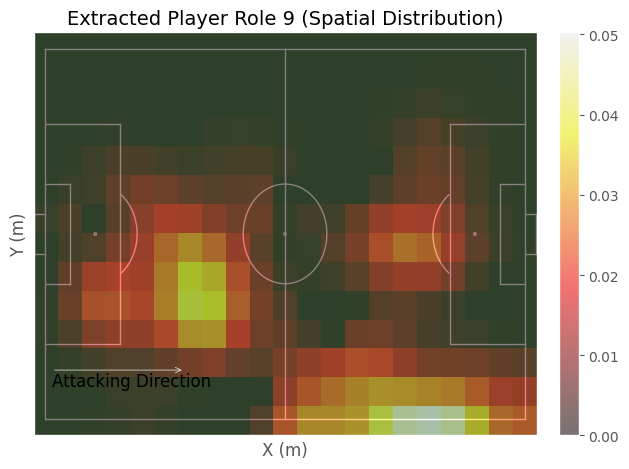

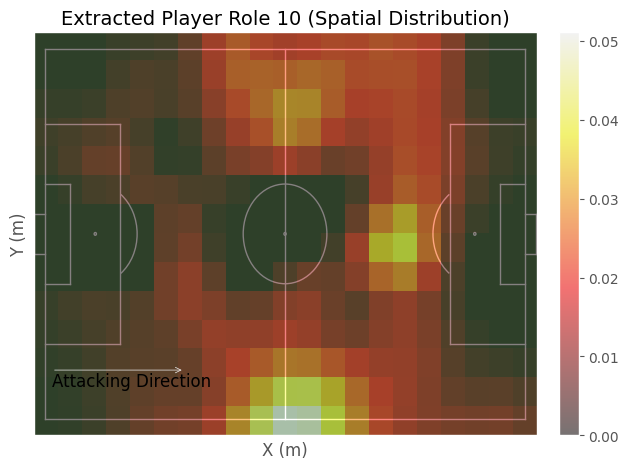

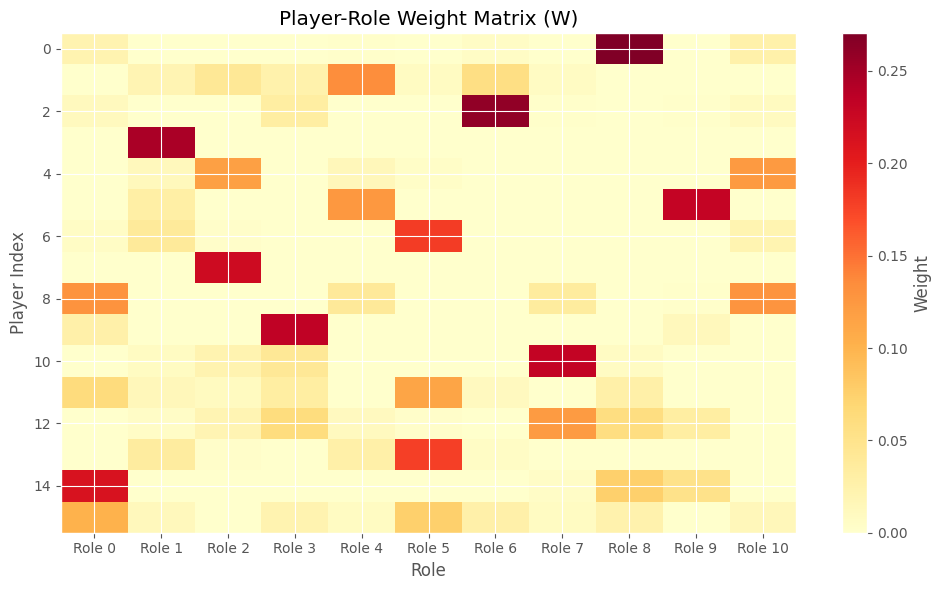

VfL Bochum 1848:Bayer 04 Leverkusen
Number of players: 16
Number of roles (K): 11
Number of bins (L): 294
Grid shape: (14, 21)
Reconstruction error: 0.6074

Player role assignments (dominant role per player):
[ 1  4  7  3 10  0  0  7  9  9  3  6  2  8  0  9]


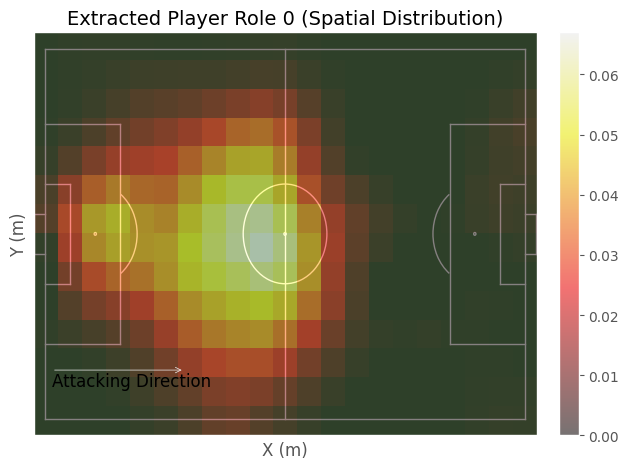

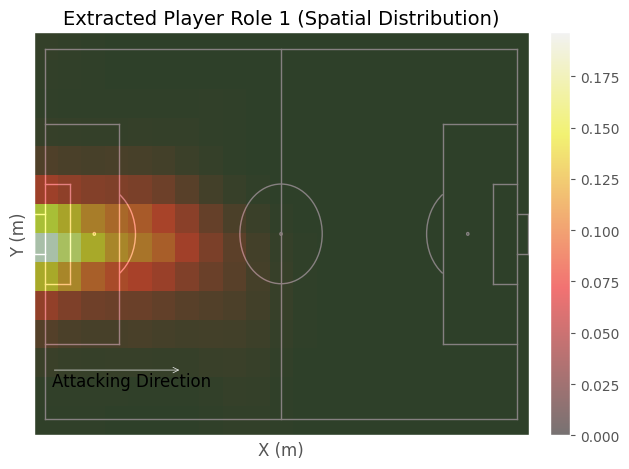

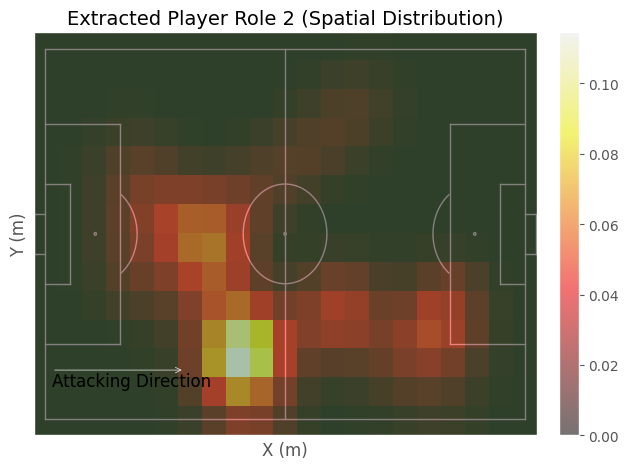

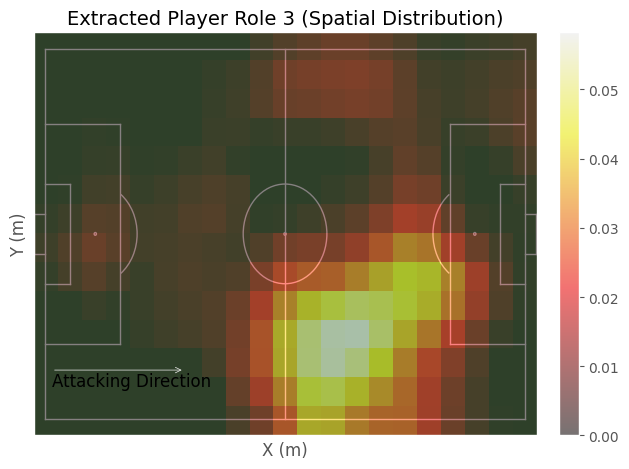

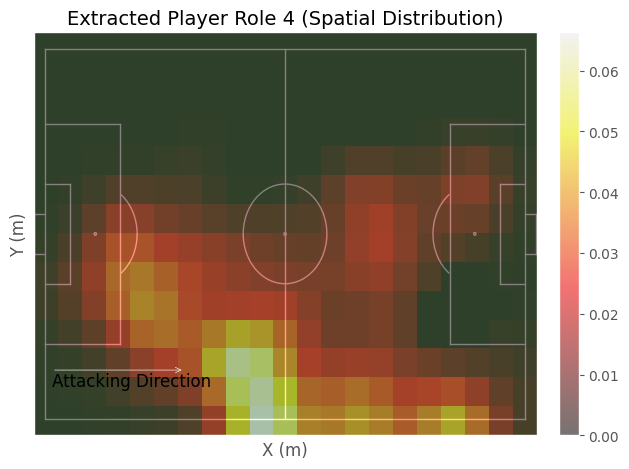

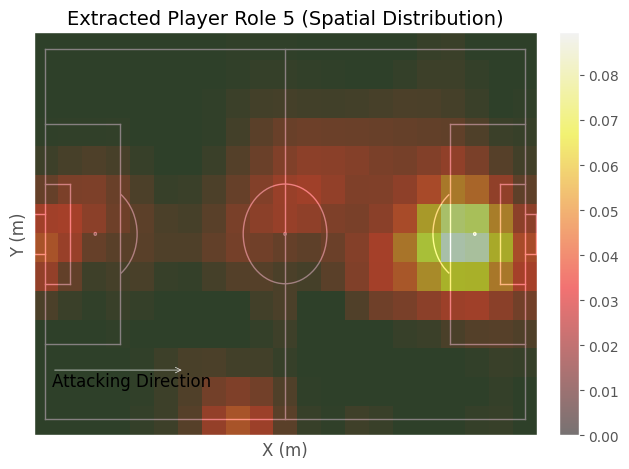

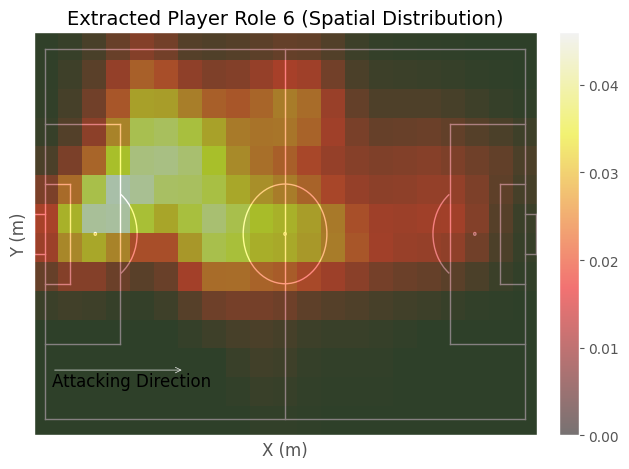

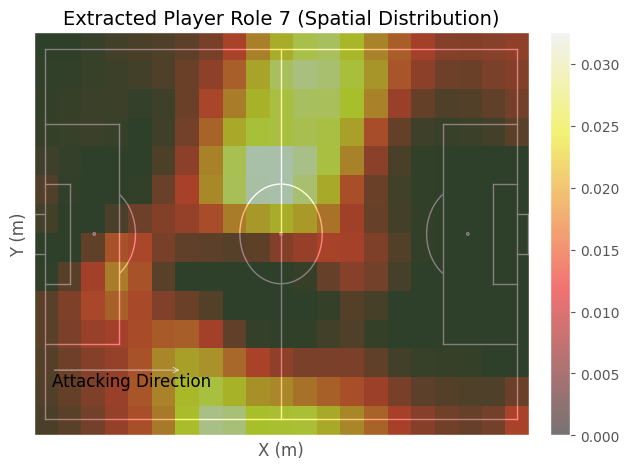

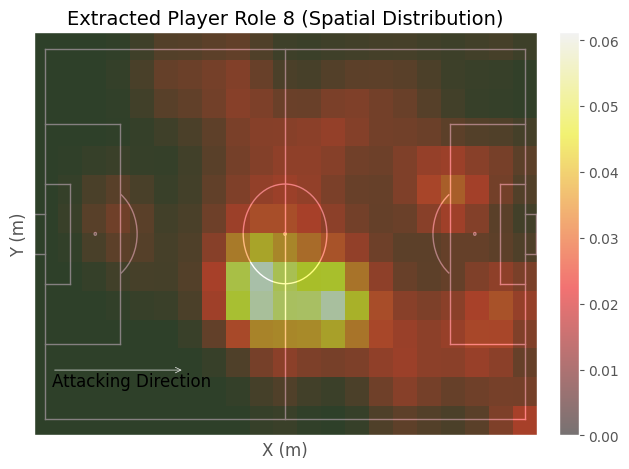

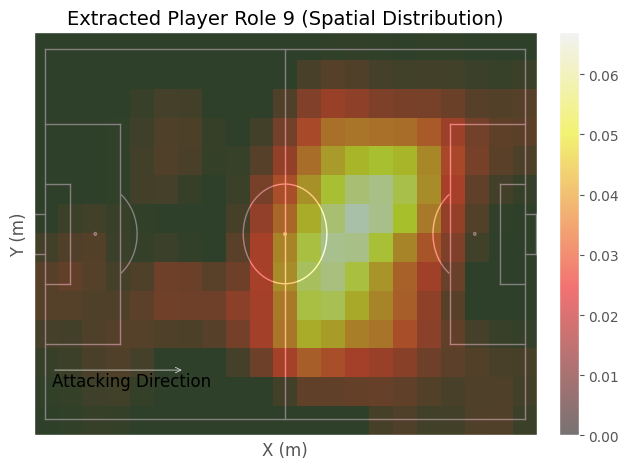

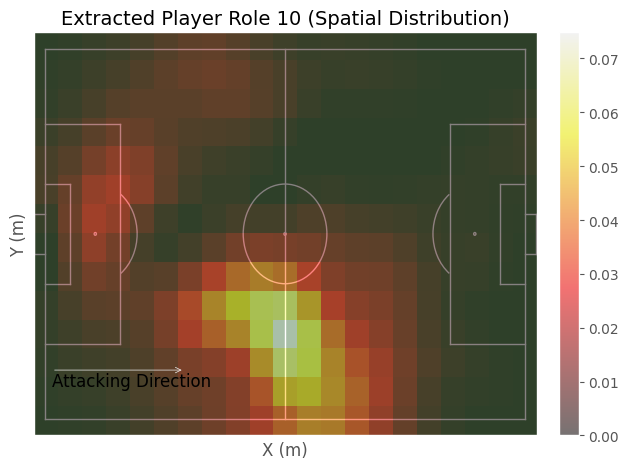

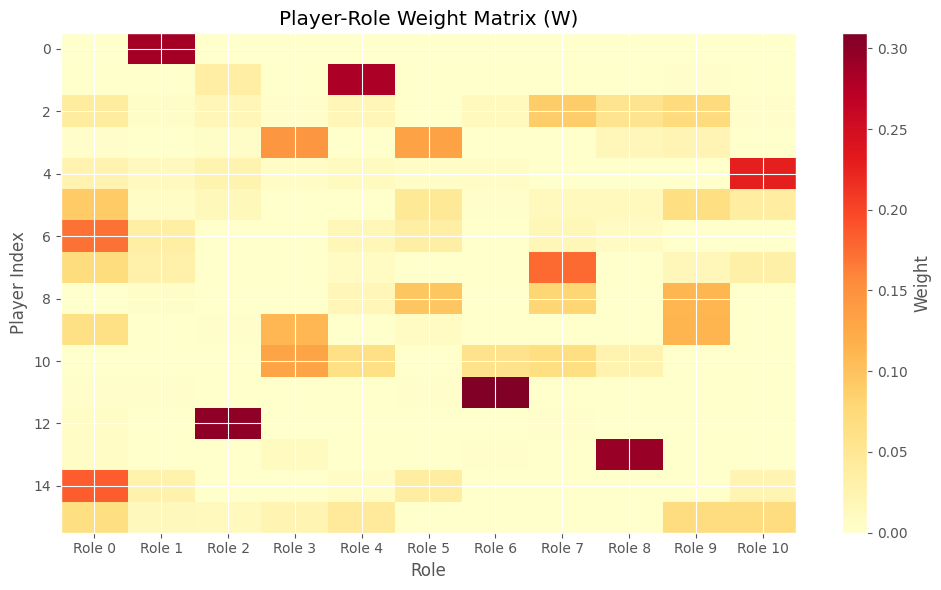

Fortuna Düsseldorf:FC St. Pauli
Number of players: 15
Number of roles (K): 11
Number of bins (L): 294
Grid shape: (14, 21)
Reconstruction error: 0.5799

Player role assignments (dominant role per player):
[ 7  2  7  8  3  9  2 10  0  9  6  4  6  9  1]


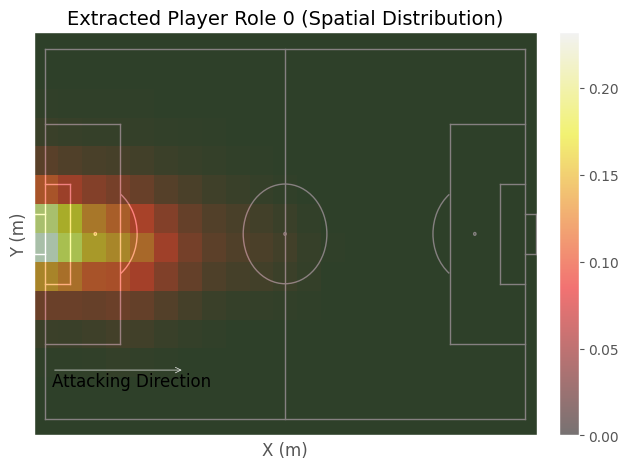

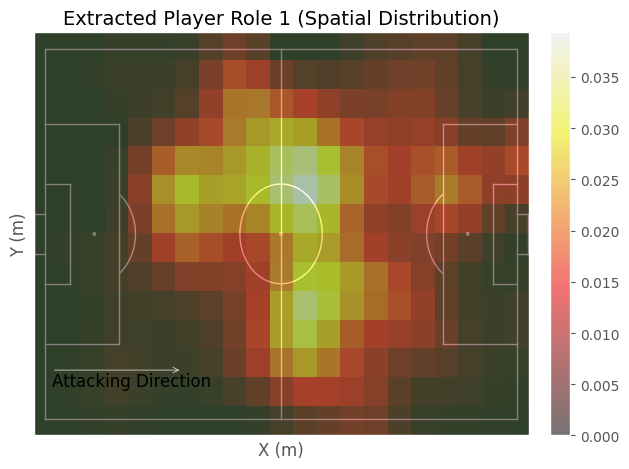

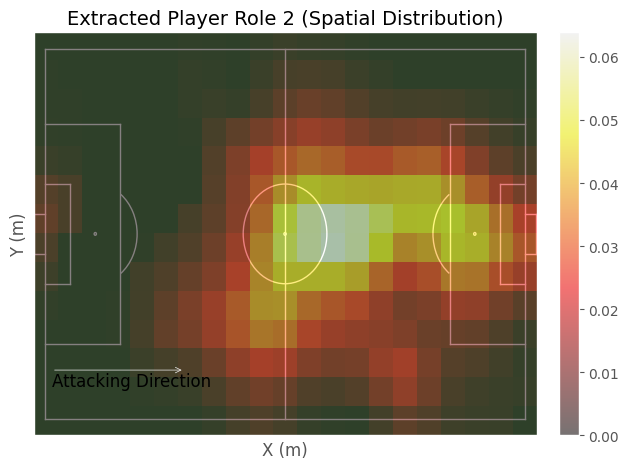

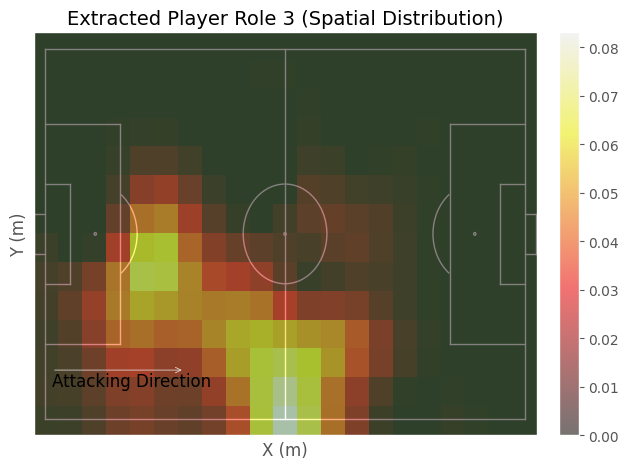

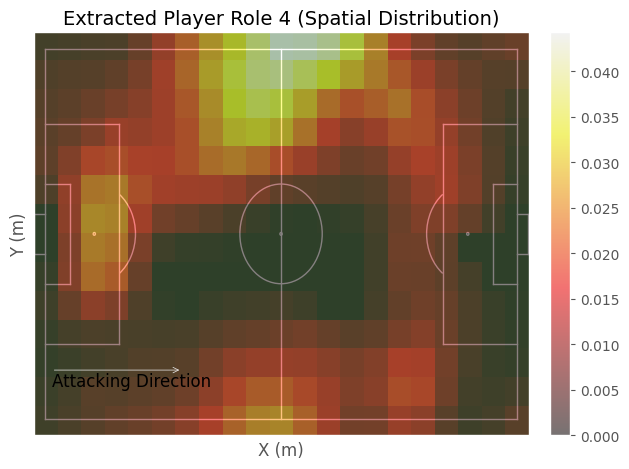

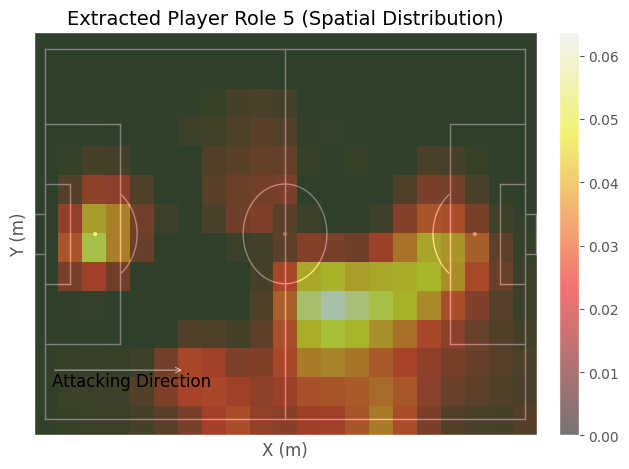

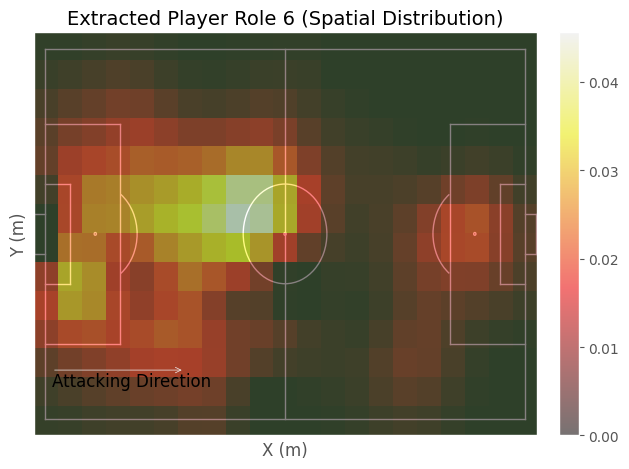

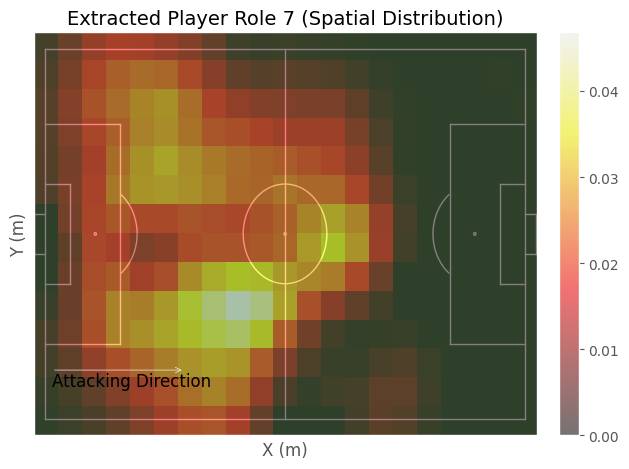

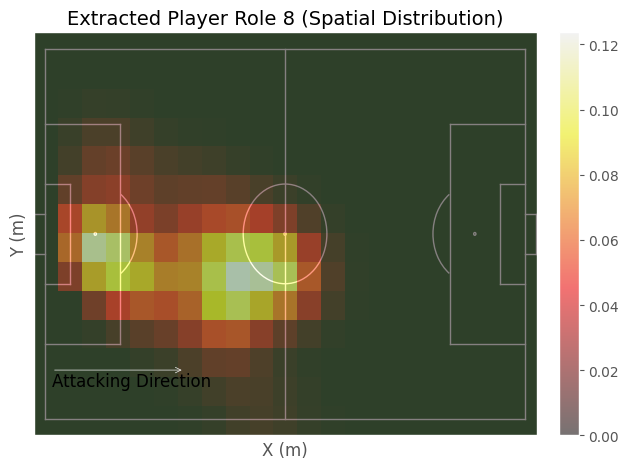

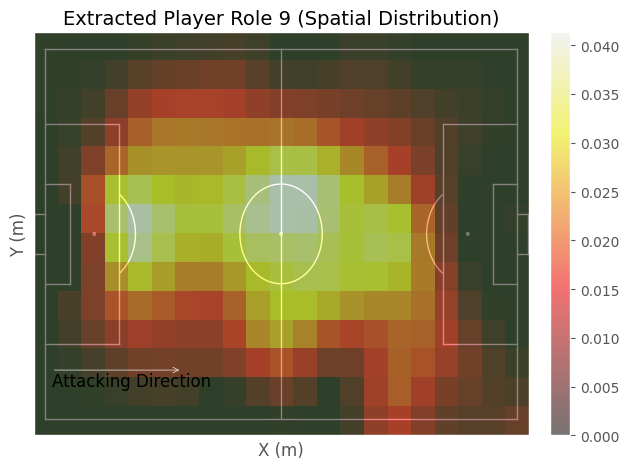

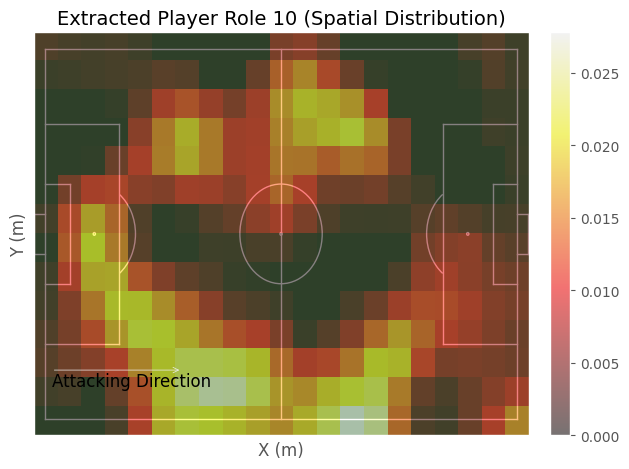

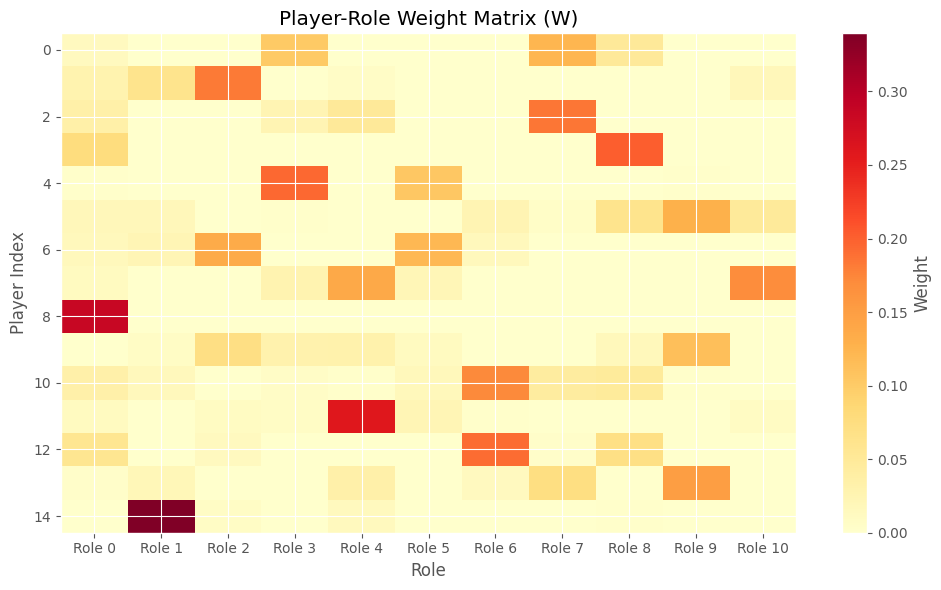

Fortuna Düsseldorf:1. FC Kaiserslautern
Number of players: 15
Number of roles (K): 11
Number of bins (L): 294
Grid shape: (14, 21)
Reconstruction error: 0.5530

Player role assignments (dominant role per player):
[ 0  4  7  5  0  0  9  2  6  1 10  9 10  8  3]


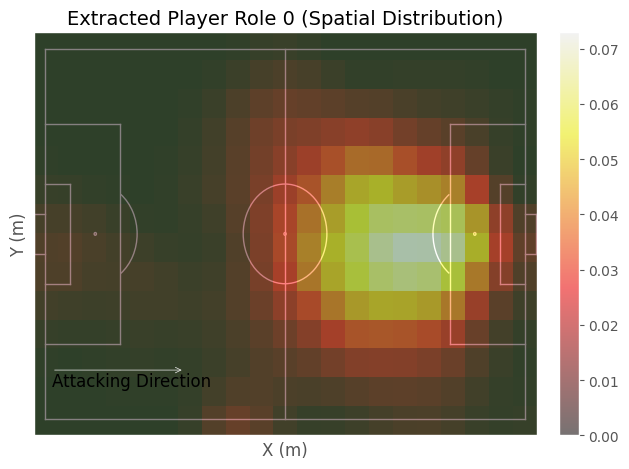

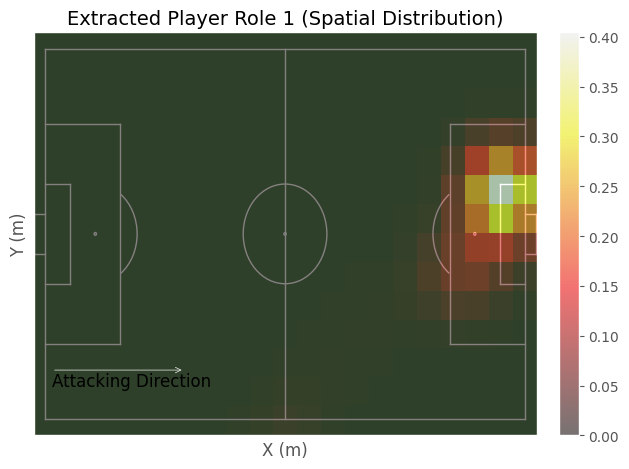

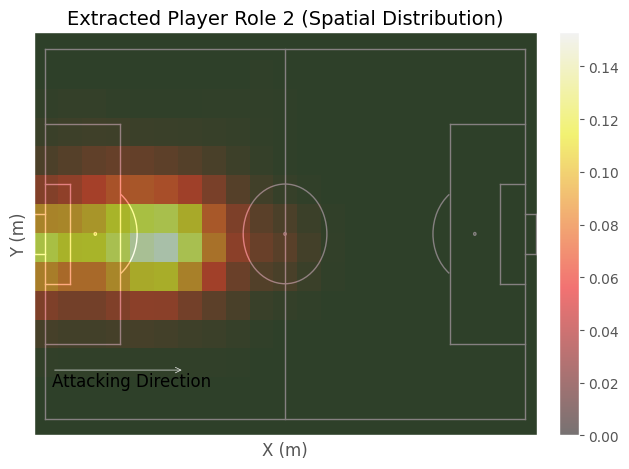

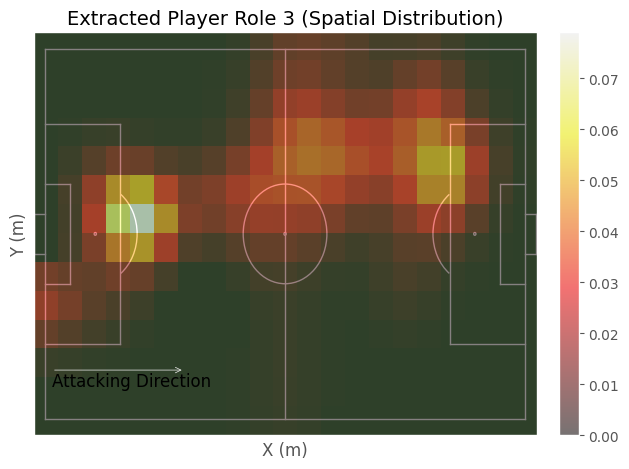

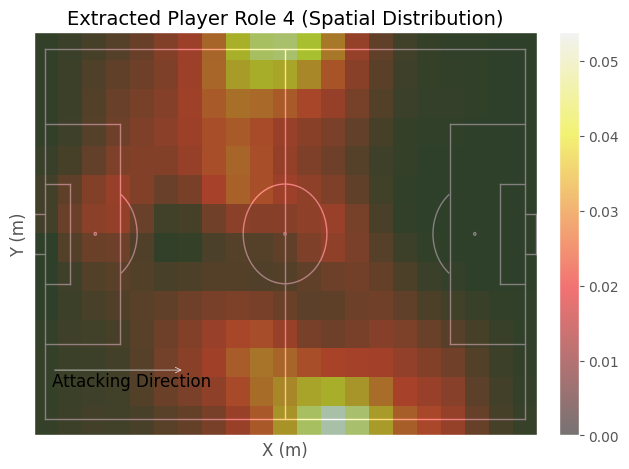

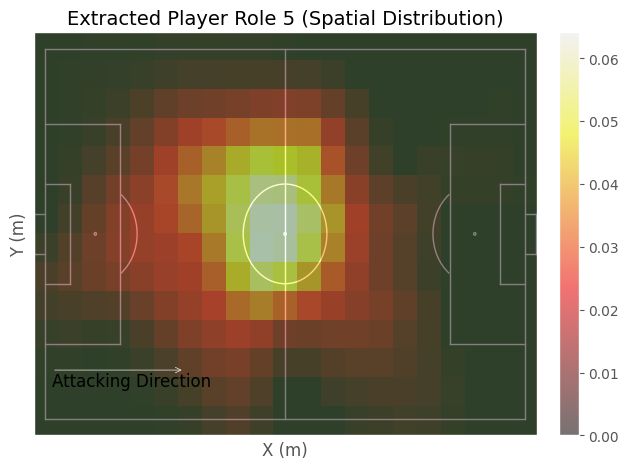

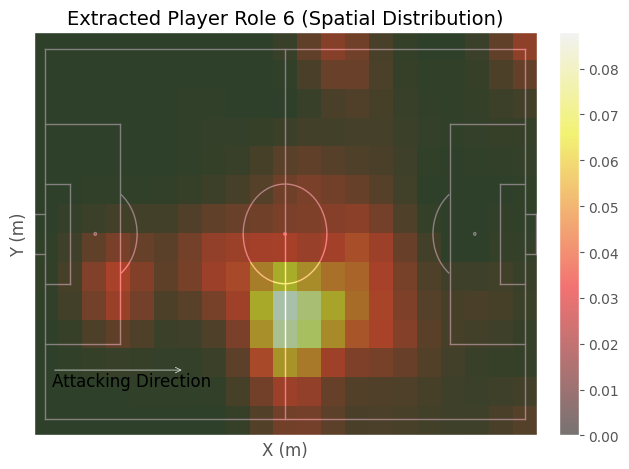

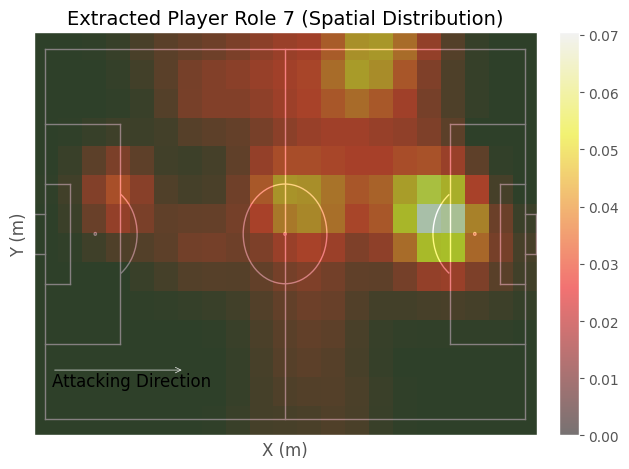

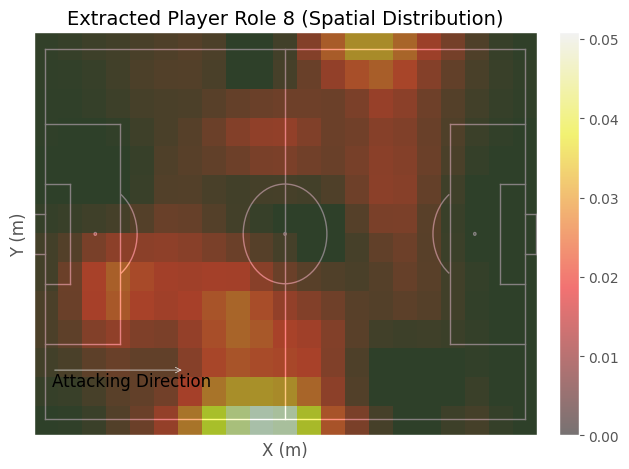

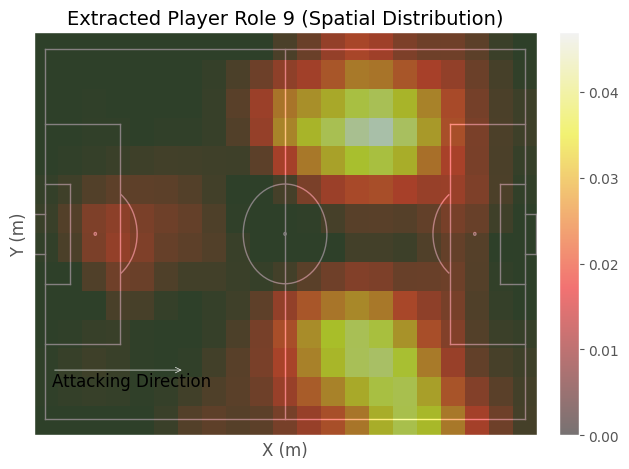

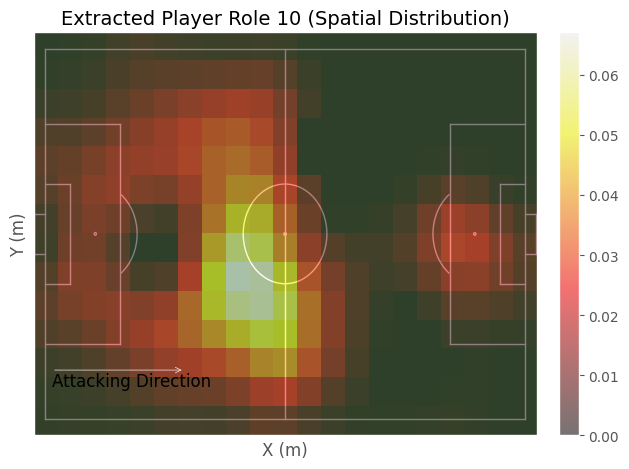

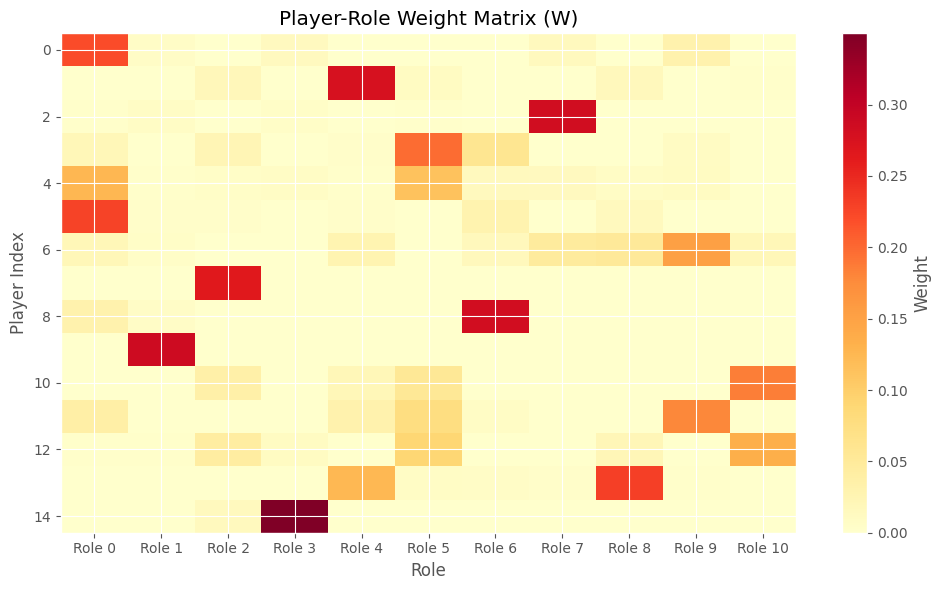

Fortuna Düsseldorf:1. FC Nürnberg
Number of players: 15
Number of roles (K): 11
Number of bins (L): 294
Grid shape: (14, 21)
Reconstruction error: 0.6197

Player role assignments (dominant role per player):
[ 5  8  4 10  0  3  1  2  0 10  7 10  0  6  9]


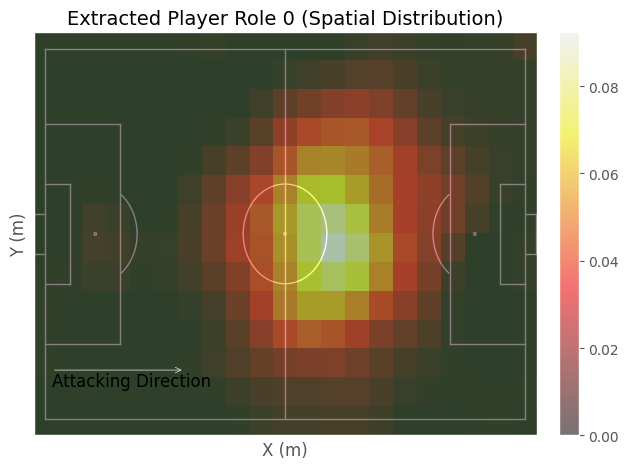

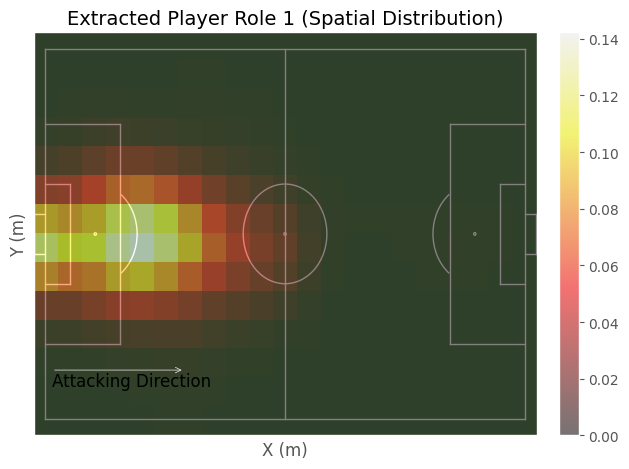

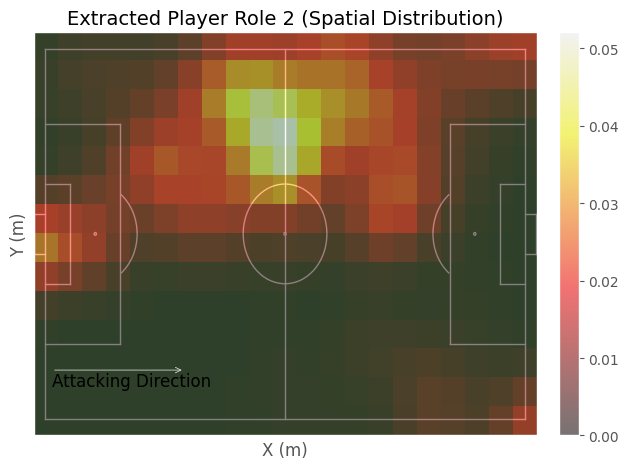

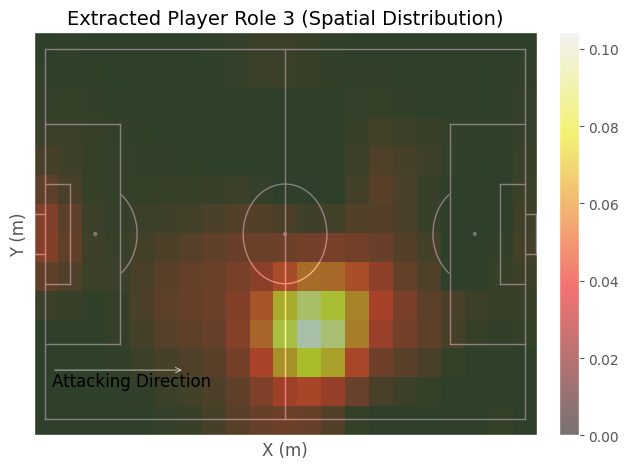

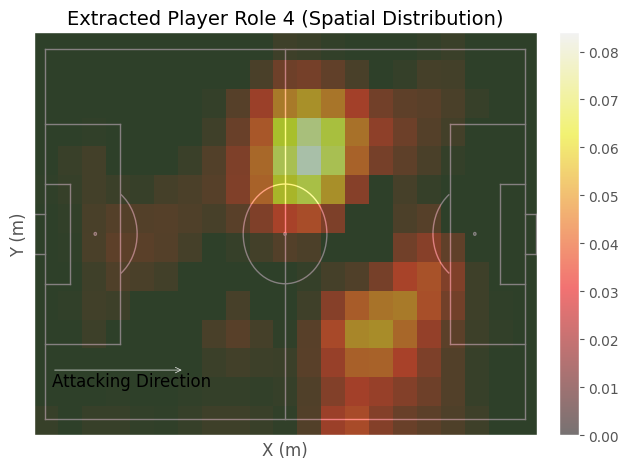

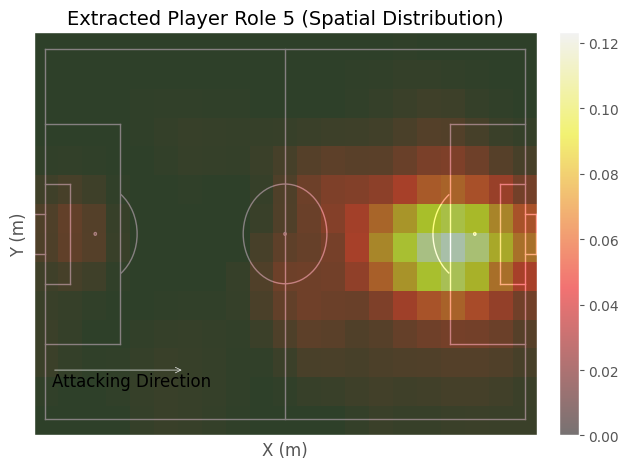

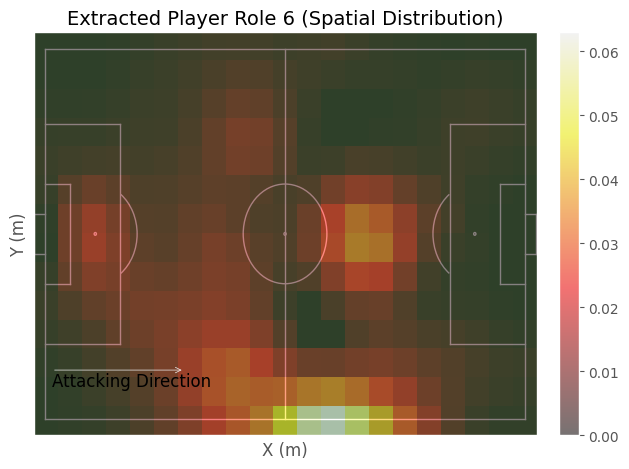

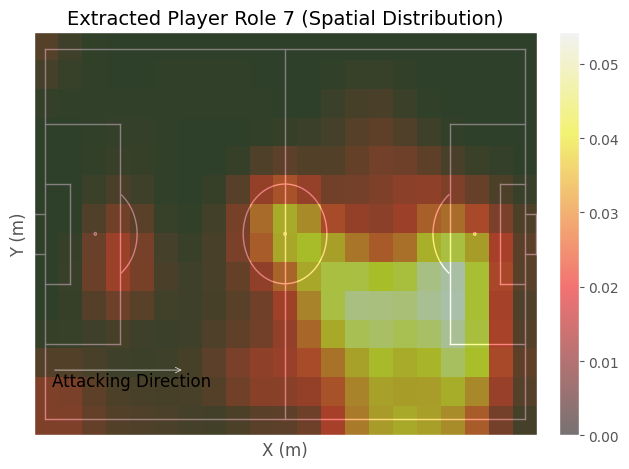

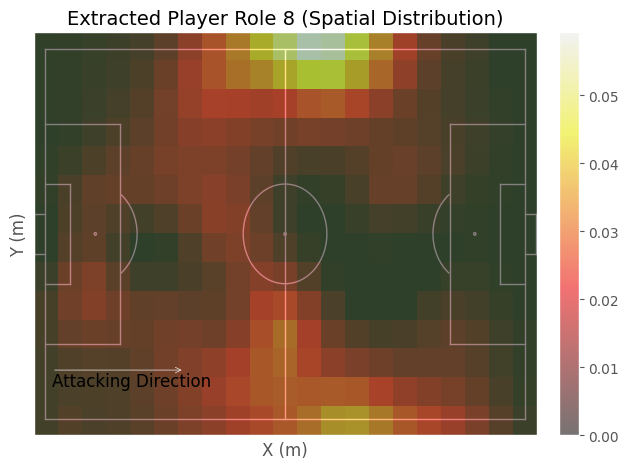

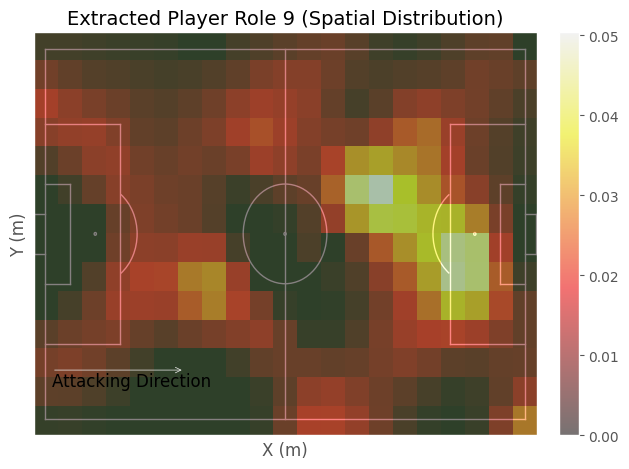

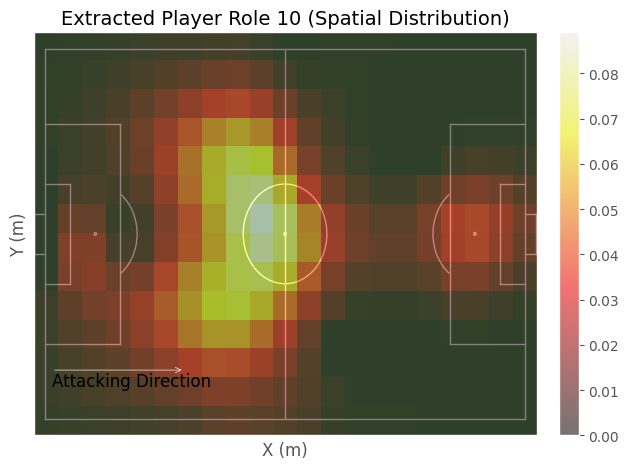

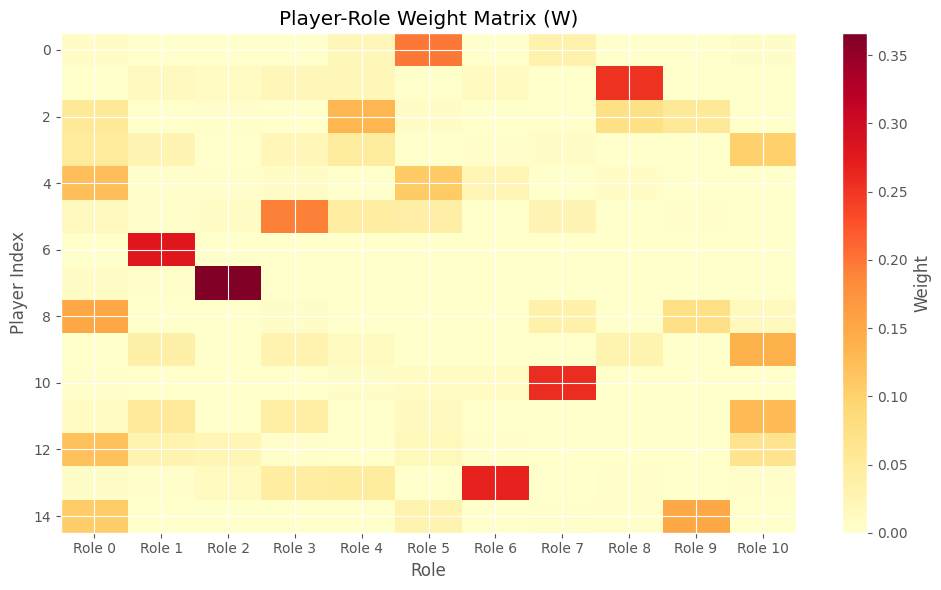

Fortuna Düsseldorf:SSV Jahn Regensburg
Number of players: 16
Number of roles (K): 11
Number of bins (L): 294
Grid shape: (14, 21)
Reconstruction error: 0.5638

Player role assignments (dominant role per player):
[ 5  2  7  8  4  0  0  8  2  9  1  7  3  4 10  6]


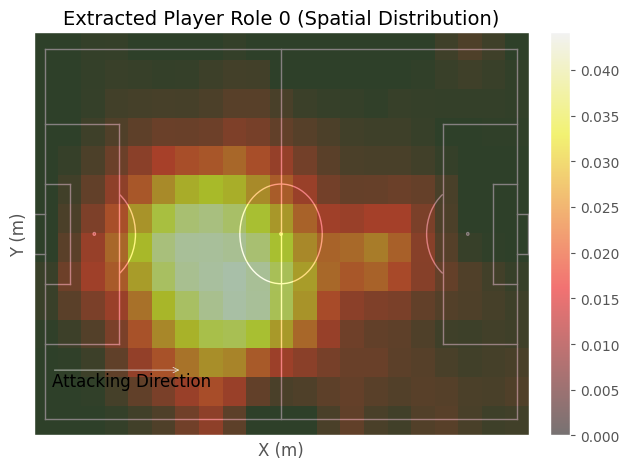

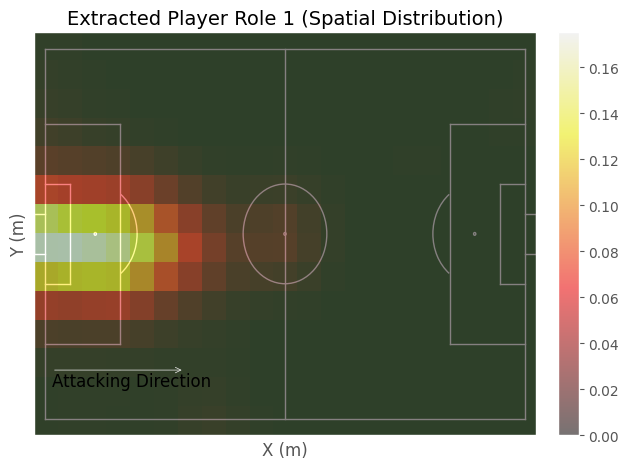

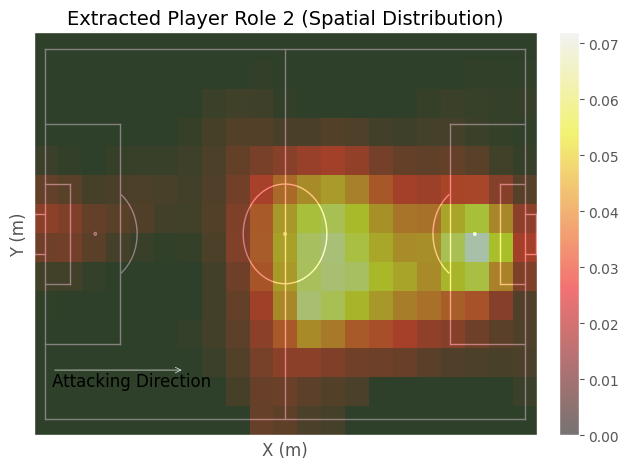

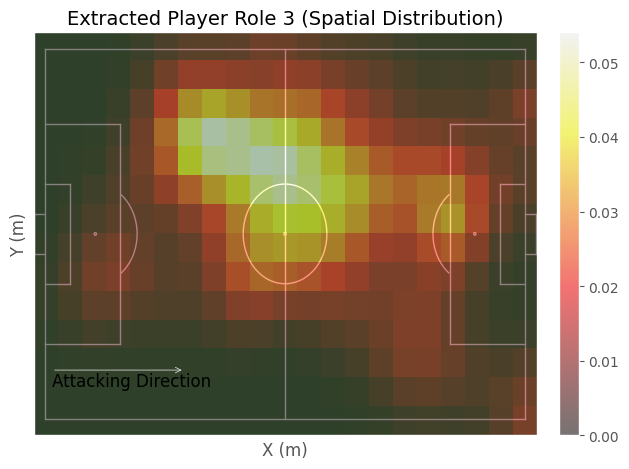

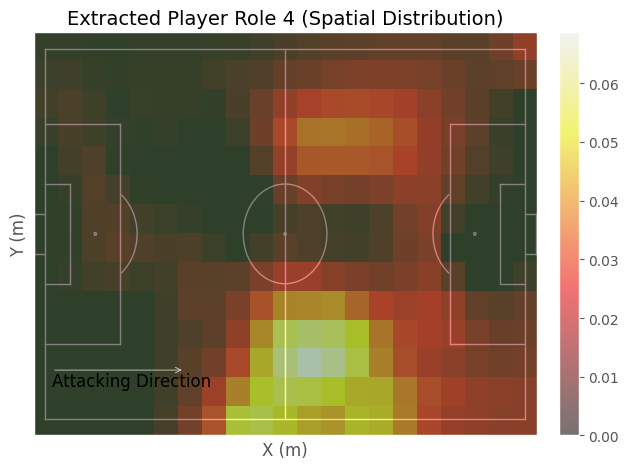

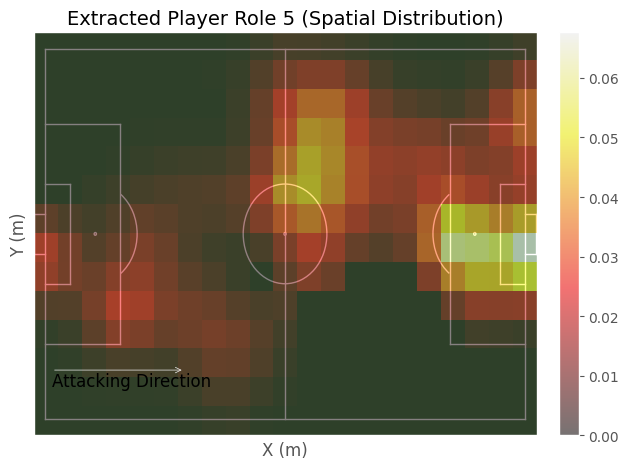

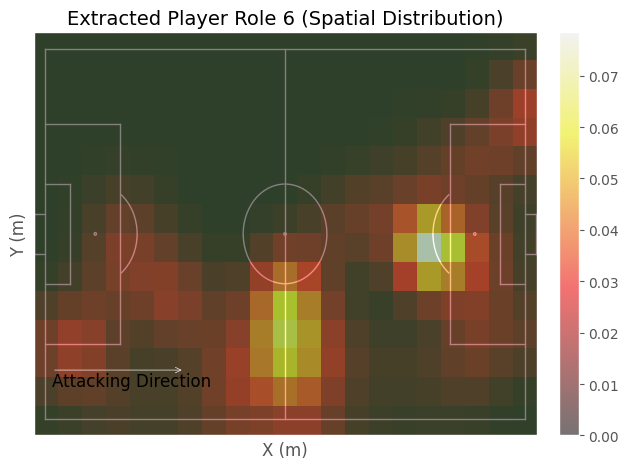

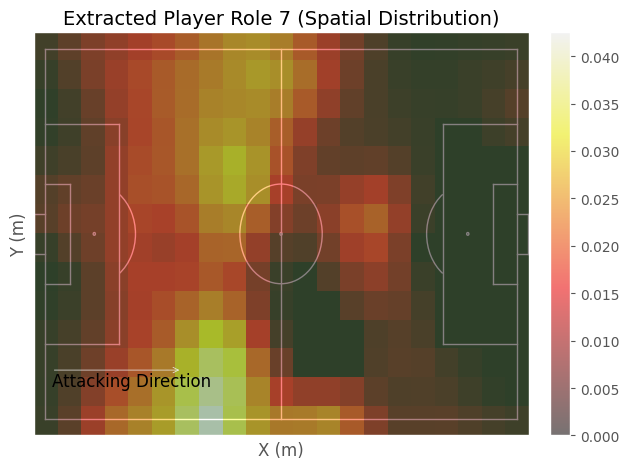

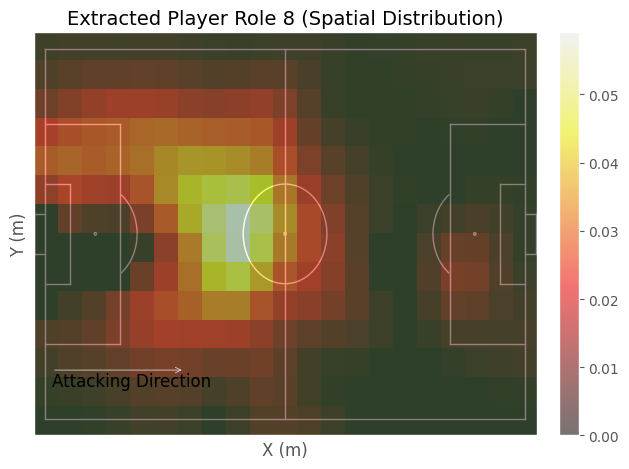

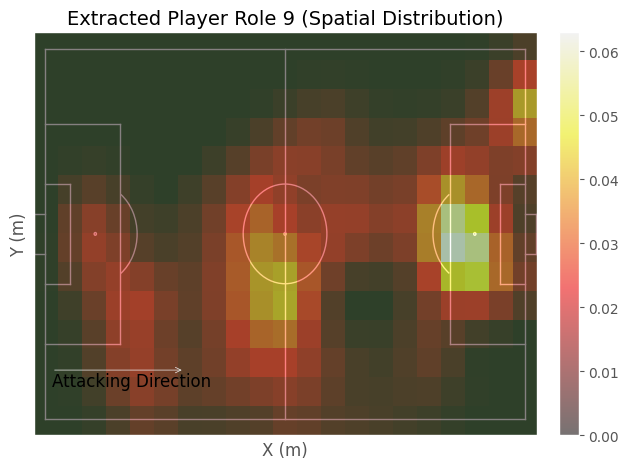

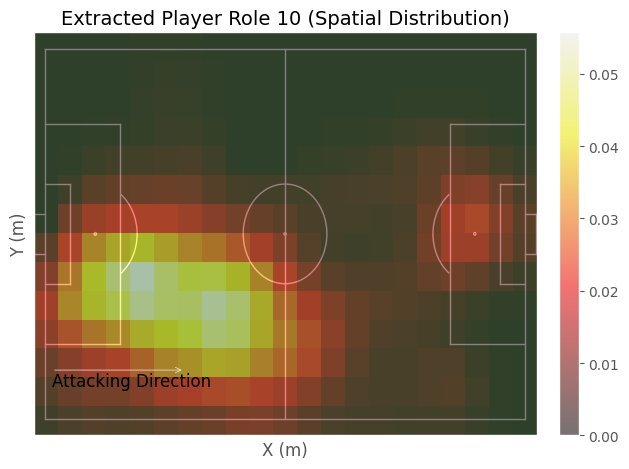

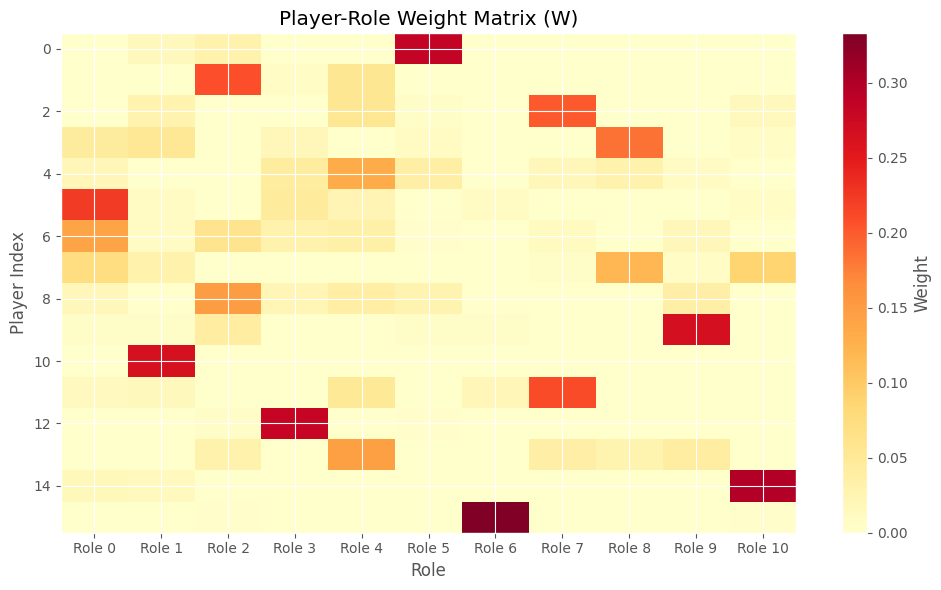

Fortuna Düsseldorf:F.C. Hansa Rostock
Number of players: 16
Number of roles (K): 11
Number of bins (L): 294
Grid shape: (14, 21)
Reconstruction error: 0.5457

Player role assignments (dominant role per player):
[ 4  8  6  7  3  9  1  8  7 10  7  7  0  4  5  2]


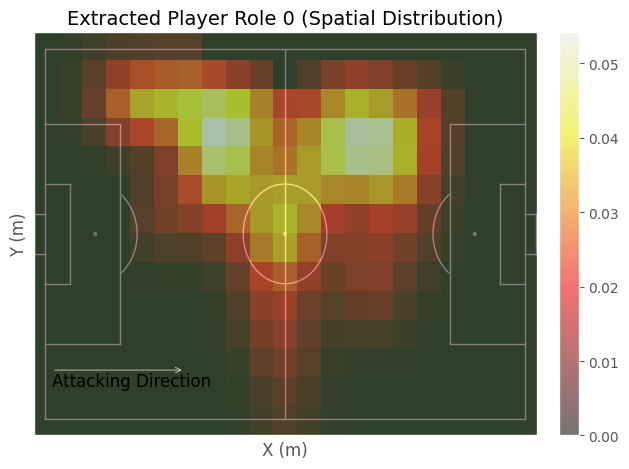

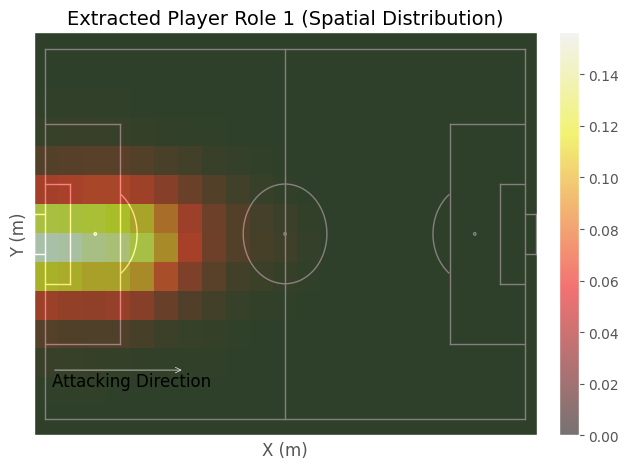

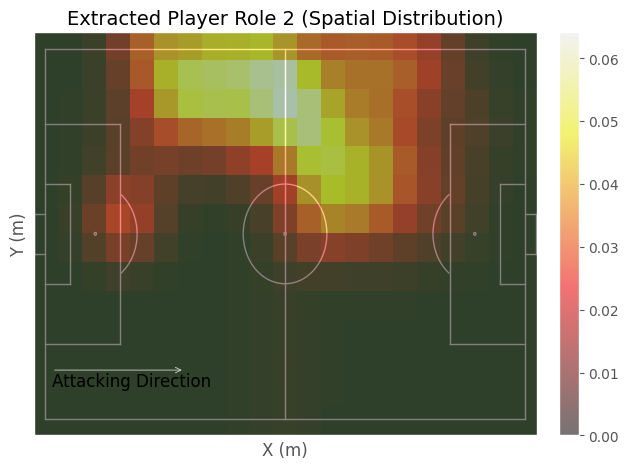

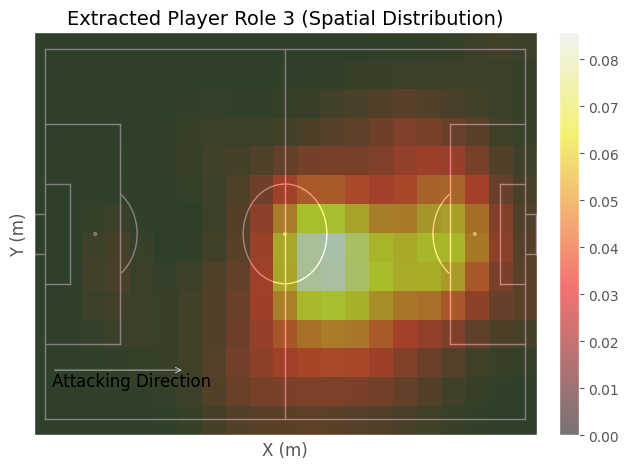

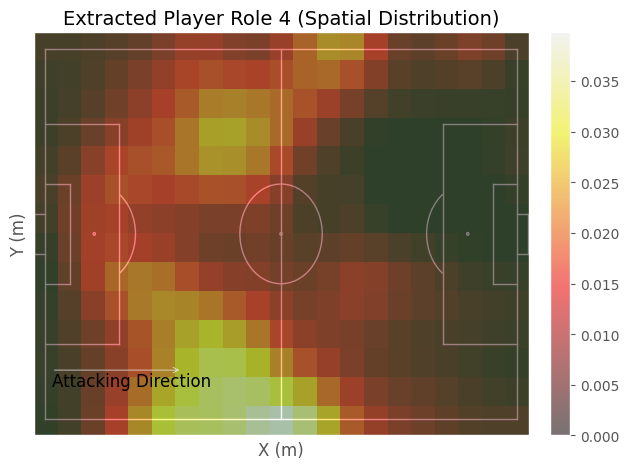

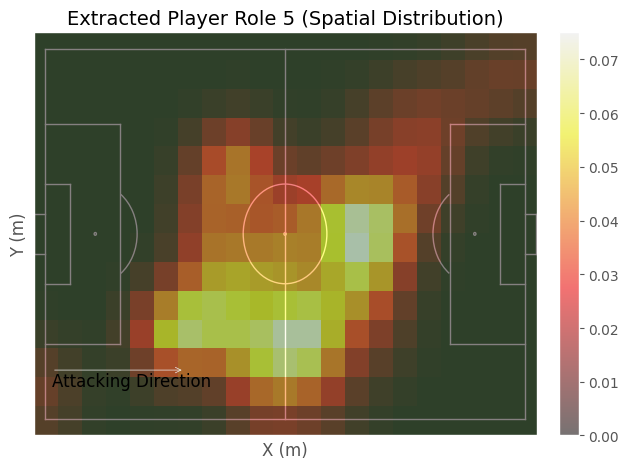

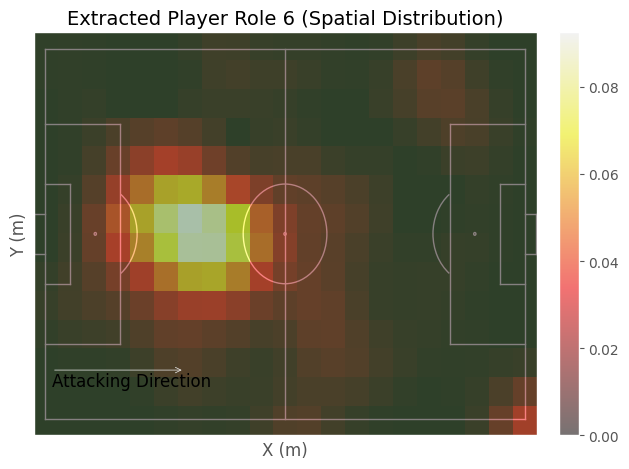

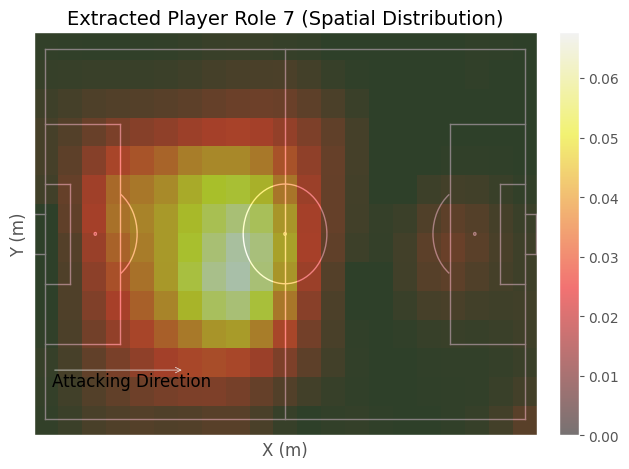

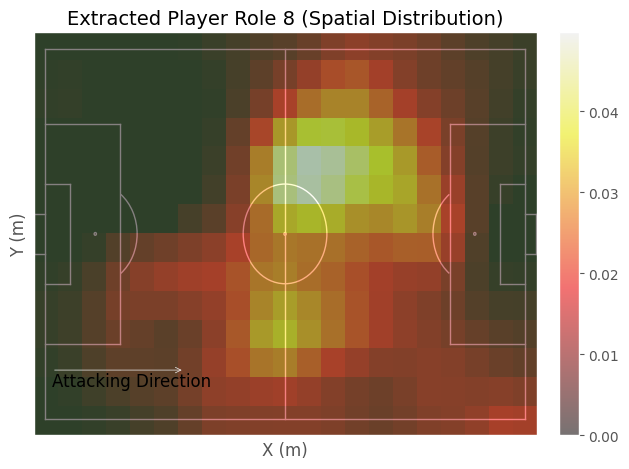

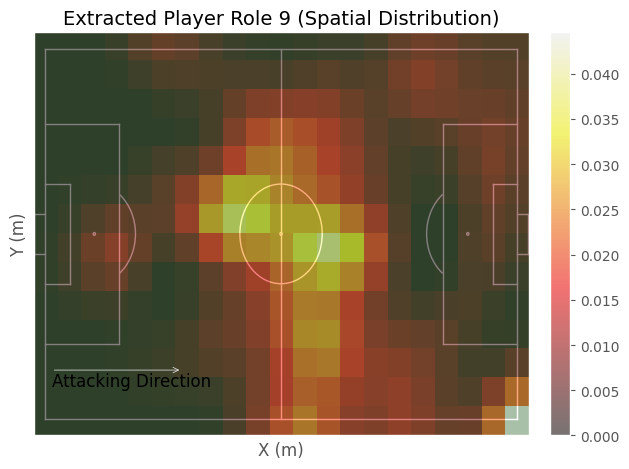

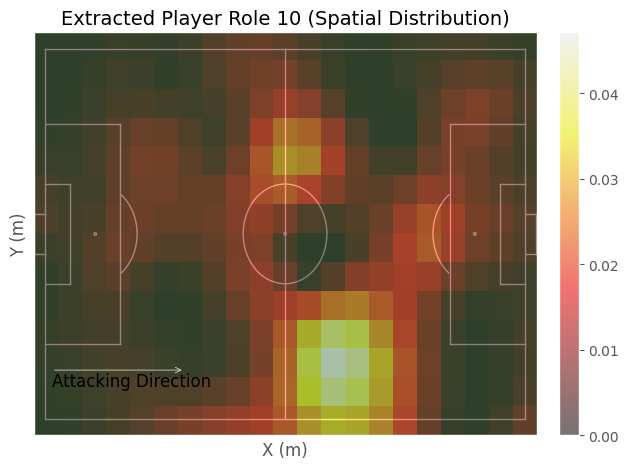

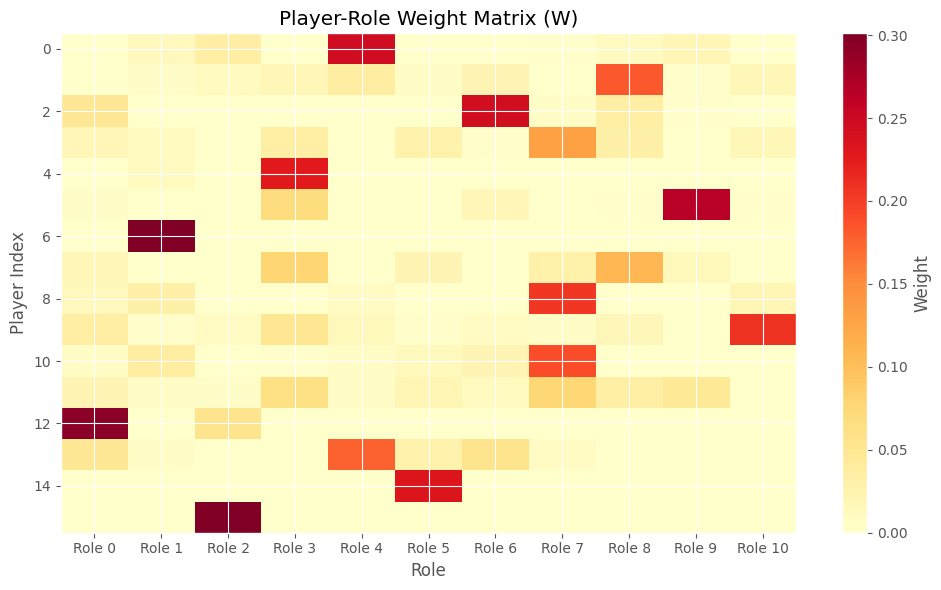

In [3]:
# Main cell for computing and aggregating player coordinates, per match formation
import os
import numpy as np

info_files = [x for x in os.listdir(path) if "matchinformation" in x]
position_files = [x for x in os.listdir(path) if "positions_raw" in x]
n_frames = 0

left_to_right_starting_home_team = {'DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WR9.xml'}
for position_file, info_file in zip(position_files, info_files):
    print(extract_game_title_from_xml_file(os.path.join(path, info_file)))
    # The function returns a tuple of five objects
    data_objects = read_position_data_xml(os.path.join(path, position_file), os.path.join(path, info_file))

    # Unpack the returned tuple (we are primarily interested in xy_objects)
    xy_objects, possession_objects, ballstatus_objects, teamsheets, pitch = data_objects
    XY_home_first, XY_home_second = xy_objects['firstHalf']['Home'], xy_objects['secondHalf']['Home']
    XY_away_first, XY_away_second = xy_objects['firstHalf']['Away'], xy_objects['secondHalf']['Away']

    # Flip coords to standardize playing direction from left -> right
    if position_file in left_to_right_starting_home_team:  # home starts in left, away starts in right
        XY_away_first.reflect('y')  # away starts in right in the first half, need to flip
        XY_home_second.reflect('y')  # home switches to right in second half, need to flip
    else:
        XY_home_first.reflect('y')  # home starts in right in the first half, need to flip
        XY_away_second.reflect('y')  # away switches to right in second half, need to flip

    # Concatenate the two halfs for the home team and away
    XY_home = np.concatenate((XY_home_first.xy, XY_home_second.xy), axis=0)
    XY_away = np.concatenate((XY_away_first.xy, XY_away_second.xy), axis=0)

    # Remove columns that are entirely NaN
    XY_home = XY_home[:, ~np.all(np.isnan(XY_home), axis=0)]
    XY_away = XY_away[:, ~np.all(np.isnan(XY_away), axis=0)]

    # Get the roles for each team
    results = extract_roles(
        XY_home,  # Convert DataFrame to numpy array
        pitch_xlim=pitch.xlim,
        pitch_ylim=pitch.ylim,
        bin_size=5.0,  # 5m x 5m bins as specified
        sigma=1.0,  # Gaussian smoothing parameter
        n_roles=11,  # Number of latent roles (adjustable)
        max_iter=500,
        random_state=42
    )

    # Display results summary
    print(f"Number of players: {results['n_players']}")
    print(f"Number of roles (K): {results['n_roles']}")
    print(f"Number of bins (L): {results['n_bins']}")
    print(f"Grid shape: {results['grid_shape']}")
    print(f"Reconstruction error: {results['reconstruction_error']:.4f}")
    print(f"\nPlayer role assignments (dominant role per player):")
    print(results['player_role_assignments'])

    role_heatmaps = get_role_heatmaps(results['B'], results['grid_shape'])
    n_roles = results['n_roles']  # Get the total number of roles

    # Iterate through the heatmaps and plot each one in its own figure
    for k, heatmap in enumerate(role_heatmaps):
        # Hardcoded limit values from y_lim and x_lim in Pitch
        x_min, x_max = -55, 55
        y_min, y_max = -37, 37
        # Custom cmap 
        original_cmap = plt.cm.get_cmap('hot')
        transparent_cmap = original_cmap
        transparent_cmap.set_bad(color=(0, 0, 0, 0))

        fig, ax = plt.subplots()  # Adjust figsize as needed for a single plot
        pitch.plot(ax=ax)
        ax.set_facecolor('#538053')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.annotate("Attacking Direction", xy=(-51, -25), xytext=(-51, -28), xycoords="data", fontsize=12)
        ax.annotate("", xy=(-22, -25), xytext=(-51, -25), xycoords="data",
                    arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), ha="center", va="top")
        # The heatmap is plotted on top with alpha for transparency
        im = ax.imshow(heatmap, origin='lower', cmap=transparent_cmap, aspect='auto', alpha=0.5,
                       extent=(x_min, x_max, y_min, y_max))

        ax.set_title(f'Extracted Player Role {k} (Spatial Distribution)', fontsize=14)
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')

        # 5. Add colorbar for this plot
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        # 6. Adjust layout and show the individual figure
        plt.tight_layout()
        plt.show()

    # Visualize player-role weight matrix (This part remains a single plot)
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(results['W'], cmap='YlOrRd', aspect='auto')
    ax.set_xlabel('Role')
    ax.set_ylabel('Player Index')
    ax.set_title('Player-Role Weight Matrix (W)')
    ax.set_xticks(range(results['n_roles']))
    ax.set_xticklabels([f'Role {k}' for k in range(results['n_roles'])])
    plt.colorbar(im, ax=ax, label='Weight')
    plt.tight_layout()
    plt.show()




# Utils/Experimentations

In [ ]:
# Role Detection using NMF
# Following the methodology from Section 3 "Defining and Allocating Roles"

from roles import extract_roles, get_role_heatmaps
import matplotlib.pyplot as plt

file_name_pos = "DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOH.xml"
file_name_infos = "DFL_02_01_matchinformation_DFL-COM-000002_DFL-MAT-J03WOH.xml"
file_name_events = "DFL_03_02_events_raw_DFL-COM-000002_DFL-MAT-J03WOH.xml"

# Load data
xy_objects, events, pitch = load_data(path, file_name_pos, file_name_infos, file_name_events)
XY = xy_objects["firstHalf"]["Home"].xy

# Extract roles using the algorithm
results = extract_roles(
    XY,
    pitch_xlim=pitch.xlim,  # Use actual pitch limits from data
    pitch_ylim=pitch.ylim,
    bin_size=5.0,  # 5m x 5m bins as specified
    sigma=1.0,  # Gaussian smoothing parameter
    n_roles=11,  # Number of latent roles (adjustable)
    max_iter=500,
    random_state=42
)

# Display results summary
print(f"Number of players: {results['n_players']}")
print(f"Number of roles (K): {results['n_roles']}")
print(f"Number of bins (L): {results['n_bins']}")
print(f"Grid shape: {results['grid_shape']}")
print(f"Reconstruction error: {results['reconstruction_error']:.4f}")
print(f"\nPlayer role assignments (dominant role per player):")
print(results['player_role_assignments'])


In [ ]:
# Visualize the role heatmaps
role_heatmaps = get_role_heatmaps(results['B'], results['grid_shape'])

fig, axes = plt.subplots(1, results['n_roles'], figsize=(4 * results['n_roles'], 4))

for k, (ax, heatmap) in enumerate(zip(axes, role_heatmaps)):
    im = ax.imshow(heatmap, origin='lower', cmap='hot', aspect='auto',
                   extent=[pitch.xlim[0], pitch.xlim[1], pitch.ylim[0], pitch.ylim[1]])
    ax.set_title(f'Role {k}')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle('Extracted Player Roles (Spatial Distributions)', fontsize=14)
plt.tight_layout()
plt.show()

# Visualize player-role weight matrix
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(results['W'], cmap='YlOrRd', aspect='auto')
ax.set_xlabel('Role')
ax.set_ylabel('Player Index')
ax.set_title('Player-Role Weight Matrix (W)')
ax.set_xticks(range(results['n_roles']))
ax.set_xticklabels([f'Role {k}' for k in range(results['n_roles'])])
plt.colorbar(im, ax=ax, label='Weight')
plt.tight_layout()
plt.show()


In [ ]:
# Define paths and filenames. Note that executing this code can take several minutes due of the large data the KDE-plot has to process.
file_name_pos = "DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOH.xml"
file_name_infos = "DFL_02_01_matchinformation_DFL-COM-000002_DFL-MAT-J03WOH.xml"
file_name_events = "DFL_03_02_events_raw_DFL-COM-000002_DFL-MAT-J03WOH.xml"

# Load data
xy_objects, events, pitch = load_data(path, file_name_pos, file_name_infos, file_name_events)
all_events = load_event_data(path)

# Plot Event Count
plot_event_count(all_events)

# Plot KDE
plot_kde(xy_objects, pitch)

# Plot Goal Positions
plot_goal_positions(xy_objects, events, pitch)